# Predicting customer churn

Churn prediction--predicting whether a customer will stay or leave a company--is one of the more popular applications of machine learning for business, especially among consulting companies trying to sell their services.

Typically the performance of a churn classifier (0 for customer stays, 1 for customer leaves, i.e. churns) is evaluated by a standard metric such as accuracy, precision, recall or ROC-AUC. In real-life, these metrics can be misleading, as they do not reflect the costs and benefits of the different outcomes being summarized by a given metric.

In the case of churn, these costs and benefits can be made very explicit in terms of the classifier's confusion matrix, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html.

\begin{equation*}
C =  
\begin{pmatrix}
\mathrm{true \, positives} &  \mathrm{false \, positives}  \\
\mathrm{false \, negatives} &  \mathrm{true \, negatives}
\end{pmatrix},
\end{equation*}

or, more generally, for a classifer with $n$ outcomes, the entries of the confusion matrix $C = (C_{ij})$ are the counts of observations known to be in class $i$ and predicted to be in class $j$.

To calculate a business-relevant metric, we need to know the cost for trying to retain a customer and the benefit of retaining a customer.

## Churn reward: simplest case

The first case we consider is for a single action of sending customers an email. The reward is the revenue from the customer over the next year minux expenses per customer. Let's make the assumptions more explicit, and flag the ones that are reasonable or not as an approximation of reality.

* action $a$ is defined by $a \in (0,1) \leftrightarrow (\mathrm{no\,email\,sent}, \mathrm{email\,sent})$ has a fixed cost for all customers (reasonable),
* there are no costs except the marketing action above (unreasonable)
* revenue $\mathrm{rev}$ is the same for all customers (unreasonable):

\begin{equation*}
\mathrm{rev} = \begin{cases}
0,  & \text{if customer churns} \\
\mathrm{rev}_1, & \text{if customer stays}
\end{cases}
\end{equation*}

The first task is to cast this setup as a *Markov Decision Process*

In [1]:
import os
from pathlib import Path
import pickle

from pprint import pprint

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer


from sklearn_pandas import DataFrameMapper

import fake_data_for_learning
from fake_data_for_learning import SampleValue

from risk_learning.config import filenames

%matplotlib inline

## Churn data

In [2]:
df = pd.read_csv(filenames.fake_churn)
cols = ['year', 'gender', 'age', 'profession', 'action', 'churn']
df[cols].head()

,year,gender,age,profession,action,churn
0,2008,female,35-49,self-employed,0,0
1,2008,female,35-49,unemployed,0,1
2,2008,female,35-49,salaried,1,0
3,2008,female,20-34,student,0,0
4,2008,male,50-64,salaried,0,0


In [3]:
def summarize_counts(data):
    '''
    Parameters
    ----------
    data : pandas.Series
        Data whose counts are to be summarized
    '''
    counts = data.value_counts()
    print(counts)
    counts.sort_index().plot(kind='bar')

2014    144
2013    142
2008    135
2009    128
2017    121
2016    120
2011    112
2010    112
2012    104
2015    100
Name: year, dtype: int64


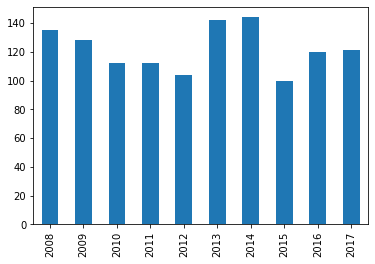

In [4]:
summarize_counts(df['year'])

female    703
male      515
Name: gender, dtype: int64


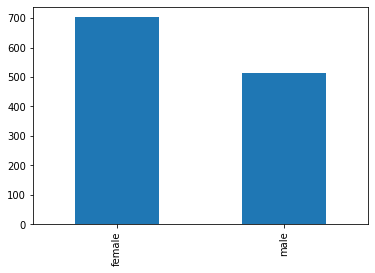

In [5]:
summarize_counts(df['gender'])

35-49    618
50-64    329
20-34    271
Name: age, dtype: int64


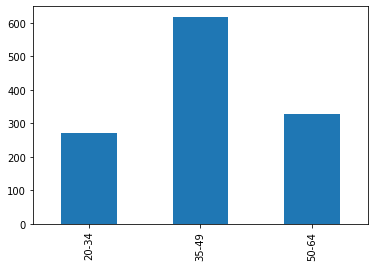

In [6]:
summarize_counts(df['age'])

salaried         528
self-employed    307
student          227
unemployed       156
Name: profession, dtype: int64


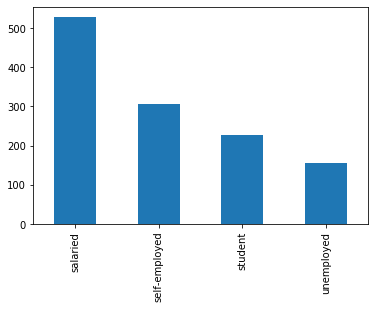

In [7]:
summarize_counts(df['profession'])

0    987
1    231
Name: action, dtype: int64


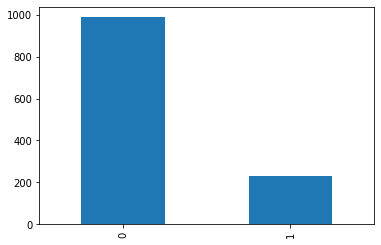

In [8]:
summarize_counts(df['action'])

0    618
1    600
Name: churn, dtype: int64


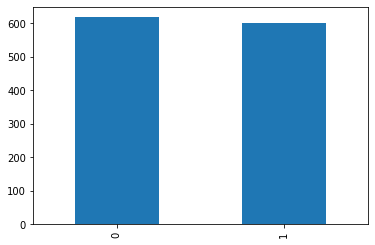

In [9]:
summarize_counts(df['churn'])

## Preprocess

In [10]:
def id_map(x):
    return x

id_trans = FunctionTransformer(id_map, validate=True)

mapper = DataFrameMapper([
    ('gender', LabelBinarizer()),
    (['age'], OneHotEncoder()),
    (['profession'], OneHotEncoder()),
    (['action'], id_trans)
])

data = pd.DataFrame(
    mapper.fit_transform(df),
    columns=mapper.transformed_names_
)
data.head()

,gender,age_x0_20-34,age_x0_35-49,age_x0_50-64,profession_x0_salaried,profession_x0_self-employed,profession_x0_student,profession_x0_unemployed,action
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [11]:
with open(filenames.churn_bn, 'rb') as f:
    churn_bn = pickle.load(f)
churn_rv = churn_bn.get_node('churn')

In [12]:
print(f"Have {df.shape[0]} customers. First action is to pick one for contact according to some policy.")
print("Take policy of contacting first customer in list.")

Have 1218 customers. First action is to pick one for contact according to some policy.
Take policy of contacting first customer in list.


In [40]:
idx=4
record = df.to_dict(orient="records")[idx]
print('Current customer:')
customer = {key: record[key] for key in record.keys() if key in ['age', 'gender', 'profession']}
pprint(customer)



print('\nWith hidden nodes:')
pprint(record)


parent_values = {key: SampleValue(record[key], churn_bn.get_node(key).label_encoder) for key in record.keys() if key in ['patience', 'thriftiness']}
# Assign action value to 1
parent_values['action'] = SampleValue(1)
res = churn_rv.rvs(parent_values=parent_values, size=10)
print(f'\nSimulated churn: {res}')
print(f'Mean of simulated churn: {np.mean(res)}')

Current customer:
{'age': '50-64', 'gender': 'male', 'profession': 'salaried'}

With hidden nodes:
{'action': 0,
 'age': '50-64',
 'churn': 0,
 'gender': 'male',
 'patience': 1,
 'profession': 'salaried',
 'thriftiness': 1,
 'year': 2008}

Simulated churn: [0 0 0 0 0 0 0 0 0 0]
Mean of simulated churn: 0.0
